In [8]:
from ParametricGraphModels.ADC_SBM import ADC_SBM, from_config
from config import Scenarios
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [6]:
n_iter = 30
res = np.zeros(n_iter).reshape(-1)
for i in tqdm(range(0,30)):
    g = from_config(Scenarios.community_relevant_heterophilic, i)
    res[i] = g.edge_homophily()

res

100%|██████████| 30/30 [01:18<00:00,  2.62s/it]


array([0.00581951, 0.00644855, 0.00616474, 0.00687369, 0.00682607,
       0.00670944, 0.00746222, 0.00651213, 0.00762708, 0.00845839,
       0.0068084 , 0.00760095, 0.0066189 , 0.00636583, 0.00667314,
       0.0063205 , 0.00649082, 0.00651052, 0.00605311, 0.00657326,
       0.00695672, 0.00619997, 0.00960708, 0.00670648, 0.00618242,
       0.00886964, 0.00739768, 0.00634321, 0.00637844, 0.00677175])

(array([ 4., 10.,  8.,  1.,  4.,  0.,  1.,  0.,  1.,  1.]),
 array([0.00581951, 0.00619826, 0.00657702, 0.00695578, 0.00733454,
        0.00771329, 0.00809205, 0.00847081, 0.00884957, 0.00922832,
        0.00960708]),
 <BarContainer object of 10 artists>)

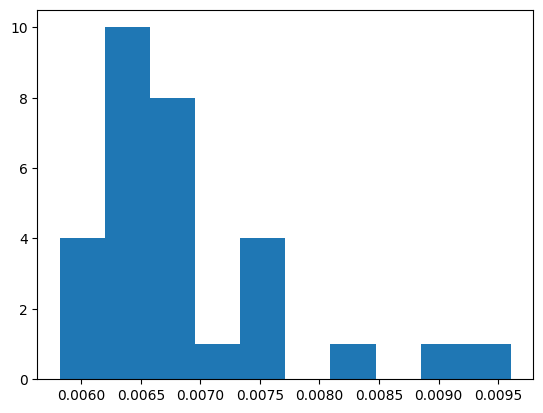

In [9]:
plt.hist(res)